In [11]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import warnings

data = pd.read_csv('SMAI-Dataset-customer-dataset/data.csv')
data = data.drop(data.columns[0], axis=1)   # drop first column - Index
data = data.values
print(data.shape)

(2000, 7)


In [12]:
def get_normalised_data(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    std[std == 0] = 1.0
    data = (data - mean) / std
    return data

In [13]:
class GMM:
    def __init__(self, iterations=150, eps=1e-4):
        self.n = None
        self.features = None
        self.k = None
        self.mean_list = None
        self.cov_list = None
        self.pi = None
        # self.z = None
        self.iterations = iterations
        self.eps = eps  # convergence criteria (epsilon)
        self.gamma_list = None

    def fit(self, data, k):
        self.n, self.features = data.shape
        self.k = k
        self.data = data
        pi = np.random.rand(self.k)
        pi = pi / np.sum(pi)

        # mean_list
        warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
        kmeans = KMeans(n_clusters=self.k, random_state=0).fit(data)
        mean_list = kmeans.cluster_centers_
        # mean_list
        
        cov_list = np.array([np.eye(self.features) for k in range(self.k)]) 
        # z = np.zeros((self.n, self.k))
        # for i in range(self.n):
        #     random_cluster = np.random.randint(0, self.k)
        #     z[i, random_cluster] = 1
        self.mean_list = mean_list
        self.cov_list = cov_list
        self.pi = pi
        # self.z = z
        
    def predict_params(self):
        iters = 0
        prev_log_likelihood = -np.inf
        while iters < self.iterations:
            log_likelihood = self.get_log_likelihood()
            gamma_list = self.e_step()
            self.m_step(gamma_list)

            if abs(prev_log_likelihood - log_likelihood) <= self.eps:
                break
            prev_log_likelihood = log_likelihood
            iters += 1
        self.gamma_list = gamma_list        # final gamma_list
        return self.mean_list, self.cov_list, self.pi

    def e_step(self):   # Expectation step
        gamma_list = np.zeros((self.n, self.k))
        for k in range(self.k):
            # calculate the posterior probability of each data point belonging to cluster k
            # for i in range(self.n):
            #     xy = multivariate_normal.pdf(self.data[i], self.mean_list[k], self.cov_list[k])
            #     gamma_list[i, k] = self.pi[k] * xy
            gamma_list[:, k] = self.pi[k] * multivariate_normal.pdf(self.data, self.mean_list[k], self.cov_list[k])
        # for i in range(self.n):
        #     for k in range(self.k):
        #         gamma_list[i, k] /= np.sum(gamma_list[i])
        gamma_list /= gamma_list.sum(axis=1, keepdims=True)
        return gamma_list
    
    # Update the parameters of the model
    def m_step(self, gamma_list):
        for k in range(self.k):
            Nk = gamma_list[:, k].sum()
            self.mean_list[k] = np.sum(self.data * gamma_list[:, k][:, np.newaxis], axis=0)
            self.mean_list[k] /= Nk
            x_minus_mu = self.data - self.mean_list[k]
            cov_k = np.zeros((self.features, self.features))
            # for i in range(self.n): # np.outer(x,x) <=> x dot x.T
            #     cov_k += gamma_list[i, k] * np.outer(x_minus_mu[i], x_minus_mu[i])
            cov_k = np.dot(gamma_list[:, k] * x_minus_mu.T, x_minus_mu)  
            self.cov_list[k] = cov_k / Nk
            # regularization is applied by adding a small positive value to the diagonal of each cov_mat
            self.cov_list[k] += 1e-3 * np.eye(self.features)
            self.pi[k] = Nk / self.n
    
    def get_log_likelihood(self):
        # log_likelihood = 0.0
        # for i in range(self.n):
        #     li = 0.0
        #     for k in range(self.k):
        #         x = self.pi[k] * multivariate_normal.pdf(self.data[i], self.mean_list[k], self.cov_list[k])
        #         li += x
        #     log_likelihood += np.log(li)

        likelihoods = np.zeros((self.n, self.k))
        for k in range(self.k):
            # Calculate the likelihood for all data points belonging to cluster k
            likelihoods[:, k] = self.pi[k] * multivariate_normal.pdf(self.data, self.mean_list[k], self.cov_list[k])
        # Calculate the log likelihood for each data point and sum them
        log_likelihoods = np.sum(likelihoods, axis=1)
        log_likelihood = np.sum(np.log(log_likelihoods))
        return log_likelihood
    
    def likelihood_samples(self,data):
        no_samples = data.shape[0]
        likelihood = np.zeros((no_samples, self.k))
        # for k in range(self.k):
        #     for i in range(no_samples):
        #         likelihood[i, k] = self.pi[k] * multivariate_normal.pdf(data[i], self.mean_list[k], self.cov_list[k])
        for k in range(self.k):
            likelihood[:, k] = self.pi[k] * multivariate_normal.pdf(data, self.mean_list[k], self.cov_list[k])
        return likelihood

    def get_membership_values(self):
        return self.gamma_list


In [14]:
# 2.1.1
data = get_normalised_data(data)

# Vary the number of components
for no_of_clusters in range(2, 11):
    gmm = GMM(300, 1e-6)
    gmm.fit(data, no_of_clusters)
    mean_list, cov_list, pi = gmm.predict_params()
    log_likelihood = gmm.get_log_likelihood()
    # print("\nMean List: ", mean_list)
    # print("\nCovariance List: ", cov_list)
    # print("\nPi: ", pi)
    print("No of Clusters: ", no_of_clusters)
    print("Log-Likelihood:", log_likelihood)
    print()

No of Clusters:  2
Log-Likelihood: -13571.083604234926

No of Clusters:  3
Log-Likelihood: -10449.877518810426

No of Clusters:  4
Log-Likelihood: -4124.928461336134

No of Clusters:  5
Log-Likelihood: -3691.725264632527

No of Clusters:  6
Log-Likelihood: -2421.6766144161484

No of Clusters:  7
Log-Likelihood: -2491.126292309332



KeyboardInterrupt: 

In [ ]:
gmm = GMM(300, 1e-6)
gmm.fit(data, 5)
mean_list, cov_list, pi = gmm.predict_params()
likelihood = gmm.likelihood_samples(data)
gamma_list = gmm.get_membership_values()
membership_df = pd.DataFrame(gamma_list, columns=[f'Cluster {i}' for i in range(5)])
print(membership_df.head())
# print("\nGamma List: ", gamma_list)
# print("\nLikelihood: ", likelihood)

   Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4
0   0.000000        0.0        0.0        1.0   0.000000
1   0.000041        0.0        0.0        0.0   0.999959
2   0.000000        0.0        0.0        1.0   0.000000
3   0.000000        0.0        0.0        1.0   0.000000
4   0.000000        0.0        0.0        1.0   0.000000


In [ ]:
# 2.1.2
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

wine = load_wine()
X = wine.data
y = wine.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

def get_kmeans_outputs(X,k):
    kmeans = KMeans(n_clusters=k, random_state=21)
    kmeans_labels = kmeans.fit_predict(X) 
    kmeans_silhouette = silhouette_score(X, kmeans_labels)
    return kmeans_labels, kmeans_silhouette

def get_gmm_outputs(X,k):
    gmm = GMM(300, 1e-6)
    gmm.fit(X, k)
    mean_list, cov_list, pi = gmm.predict_params()
    likelihood_list = gmm.likelihood_samples(X)
    gmm_labels = np.argmax(likelihood_list, axis=1)
    gmm_silhouette = silhouette_score(X, gmm_labels) 
    return gmm_labels, gmm_silhouette

def get_bic(no_of_samples,no_of_features, log_likelihood, k):
    no_of_params = k * (no_of_features * 2 + 1)
    bic = -2 * log_likelihood + no_of_params * np.log(no_of_samples)
    return bic

def get_aic(no_of_features, log_likelihood, k):
    no_of_params = k * (no_of_features * 2 + 1)
    aic = -2 * log_likelihood + 2 * no_of_params
    return aic


In [ ]:
bic_list = []
aic_list = []

cluster_range = range(1,101)

for no_of_clusters in cluster_range:
    gmm = GMM(300, 1e-6)
    gmm.fit(X, no_of_clusters)
    mean_list, cov_list, pi = gmm.predict_params()
    log_likelihood = gmm.get_log_likelihood()
    bic_score = get_bic(X.shape[0],X.shape[1], log_likelihood, no_of_clusters)
    aic_score = get_aic(X.shape[1], log_likelihood, no_of_clusters)
    bic_list.append(bic_score)
    aic_list.append(aic_score)

bic_k = np.argmin(bic_list) + 1
aic_k = np.argmin(aic_list) + 1
print("Optimal number of clusters w.r.t BIC: ", bic_k)
print("Optimal number of clusters w.r.t AIC: ", aic_k)

Optimal number of clusters w.r.t BIC:  38
Optimal number of clusters w.r.t AIC:  70


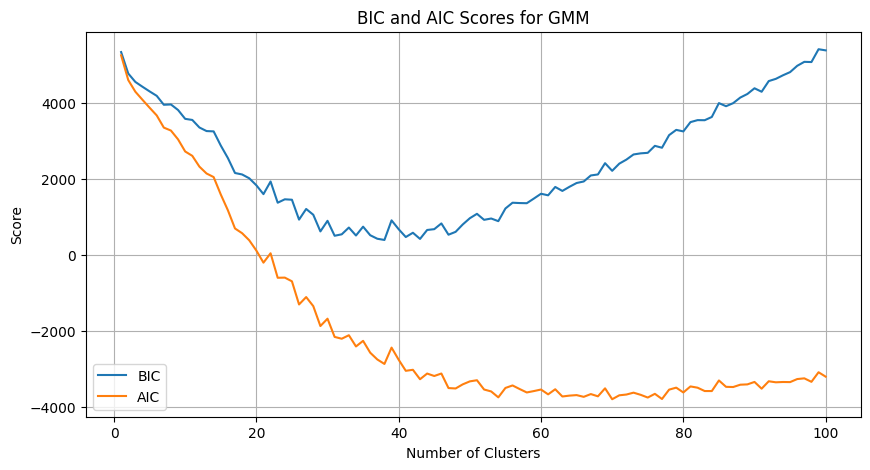

In [ ]:
# plot BIC and AIC scores
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, bic_list, label='BIC')
plt.plot(cluster_range, aic_list, label='AIC')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('BIC and AIC Scores for GMM')
plt.legend()
plt.grid(True)
plt.show()

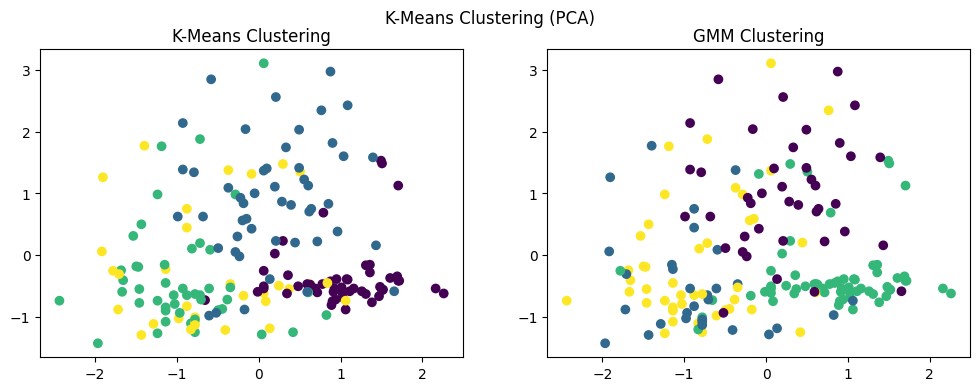

Silhouette Score (K-Means): 0.49
Silhouette Score (GMM): 0.42


In [ ]:
# Reduce 2 dimensions with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans_labels, kmeans_silhouette = get_kmeans_outputs(X_pca,4)
gmm_labels, gmm_silhouette = get_gmm_outputs(X_pca,4)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax1.scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis')
ax1.set_title('K-Means Clustering')
ax2.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis')
ax2.set_title('GMM Clustering')
plt.suptitle('K-Means Clustering (PCA)')
plt.show()

print(f"Silhouette Score (K-Means): {kmeans_silhouette:.2f}")
print(f"Silhouette Score (GMM): {gmm_silhouette:.2f}")

**OBSERVATIONS:**
1. The clusters in K-Means are more well defined and are spherical and of equal size.
2. The clusters in GMM are variable in size and shape and are not well defined.
3. The boundaries of clusters are not well defined in GMM whereas they are well defined in K-Means.
4. The silhouette score for K-Means is higher than that of GMM, thus K-Means is a better-clustering algorithm in this case.